<a href="https://colab.research.google.com/github/akilasadhish/AIICBFF-CSA-/blob/main/AIICBFF_CSA__NWPURESISC_10_90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from contextlib import suppress
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
from zipfile import ZipFile
from skimage.io import imread, imsave
import tensorflow as tf

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
!pip install pyunpack
!pip install patool
from pyunpack import Archive

In [ ]:
import patoolib

if not os.path.isdir(source_dir):
  patoolib.extract_archive("/content/drive/MyDrive/NWPU-RESISC45.rar", outdir="data")

In [ ]:
source_dir = os.path.join('data', 'NWPU-RESISC45')
with suppress(FileExistsError):
    os.mkdir('data')

In [ ]:
class_names = os.listdir(source_dir)   
class_names

In [ ]:
flow_base2 = os.path.join('data', 'result')
if not os.path.isdir(flow_base2):
  # Make new directories
  os.mkdir(flow_base2)

In [ ]:
import pandas as pd
df = pd.DataFrame(list())
df.to_csv('/content/data/result/XXX.csv')


In [ ]:
!pip install -q split-folders
import splitfolders
splitfolders.ratio('/content/data/NWPU-RESISC45', output='/content/data/flow', seed=1337,  ratio=(0.2, 0.6, 0.2))

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Dense, Reshape
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Add, Concatenate, multiply, GlobalMaxPooling2D

In [ ]:
def cbam_block(cbam_feature, ratio=16):
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def channel_attention(input_feature, ratio=16):
	
	channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Keras.Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Keras.Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if tf.keras.backend.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7
	
	if tf.keras.backend.image_data_format() == "channels_first":
		channel = input_feature._keras_shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if tf.keras.backend.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Reshape, Lambda
from tensorflow.keras.backend import *

In [ ]:
def Resnet50_model1(input_shape, num_classes=45):
  
  model = ResNet50(include_top=False, input_shape=input_shape, pooling='avg', weights= 'imagenet')
  for layer in model.layers[0:-95]:
    layer.trainable = False


  model1 = model.layers[-2].output
  model1 = channel_attention(model1,16)
  model1 = GlobalAveragePooling2D()(model1)
  model1 = Dense(24, activation = "relu")(model1)
  model1 = BatchNormalization()(model1)
  print(model1.shape)
  
  model2 = model.layers[-12].output
  model2 = channel_attention(model2,16)
  model2 = GlobalAveragePooling2D()(model2)
  model2 = Dense(24, activation = "relu")(model2)
  model2 = BatchNormalization()(model2)
  print(model2.shape)
  
  model3 = model.layers[-22].output
  model3 = cbam_block(model3,16)
  model3 = GlobalAveragePooling2D()(model3)
  model3 = Dense(24, activation = "relu")(model3)
  model3 = BatchNormalization()(model3)
  print(model3.shape)
  

  model4 = model.layers[-34].output
  model4 = cbam_block(model4,16)
  model4 = GlobalAveragePooling2D()(model4)
  model4 = Dense(24, activation = "relu")(model4)
  model4 = BatchNormalization()(model4)
  print(model4.shape)
  
  model5 = model.layers[-96].output
  model5 = cbam_block(model5,16)
  model5 = GlobalAveragePooling2D()(model5)
 

  model5 = Dense(24, activation = "relu")(model5)
  model5 = BatchNormalization()(model5)
  print(model5.shape)

  x = Concatenate()([model1, model2, model3, model4, model5])
  
  predictions = Dense(45, activation="softmax")(x)

  model = tf.keras.Model(inputs = model.input, outputs = predictions)
  return model

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.optimizers import Adam,Nadam, SGD

trainset_dir = '/content/data/flow/train'
valset_dir = '/content/data/flow/test/'
testset_dir = '/content/data/flow/val/'

num_classes = 45
learning_rate = 1e-2
momentum = 0.9
batch_size = 16
input_shape = (224, 224, 3)
train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=preprocess_input,
        rotation_range = 60,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode='nearest')
val_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(
    trainset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical')
val_generator = val_datagen.flow_from_directory(
    valset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical', shuffle = False)
test_generator = test_datagen.flow_from_directory(
    testset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical', shuffle= False)

optim = SGD(learning_rate=learning_rate, momentum=momentum)
# optim = RMSprop(lr=learning_rate)
# optim = Adam(amsgrad=True)
model = Resnet50_model1(input_shape, num_classes = 45 )


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

In [ ]:
loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['acc'])
csv_path = '/content/data/result/XXX.csv'

In [ ]:
save_weights_path = '/content/drive/MyDrive/model_save/RSSC/10modelrssc.h5'
#You can modify the path by yourself

checkpoint = ModelCheckpoint(save_weights_path, monitor='val_acc', verbose=1, 
                             save_weights_only=True, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=32, verbose=1)
# logging = TensorBoard(log_dir=log_dir, batch_size=batch_size)
csvlogger = CSVLogger(csv_path, append=True)

callbacks = [checkpoint, reduce_lr, csvlogger]

num_epochs = 100

model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          epochs=num_epochs,
          verbose=1, 
          callbacks=callbacks, 
          validation_data=test_generator, 
          validation_steps=len(test_generator),
          workers=1)

In [ ]:
_, acc = model.evaluate(val_generator)
print("Test Accuracy: {}%".format(acc*100))

In [ ]:
test_score = model.evaluate_generator(val_generator, batch_size)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.figure(figsize=(20,20))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=21)
  plt.yticks(tick_marks, classes)
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xticks(rotation=90)
    plt.xlabel('Predicted label')

<ipython-input-52-05300ee7ddb1>:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(val_generator)


Confusion Matrix
Normalized confusion matrix


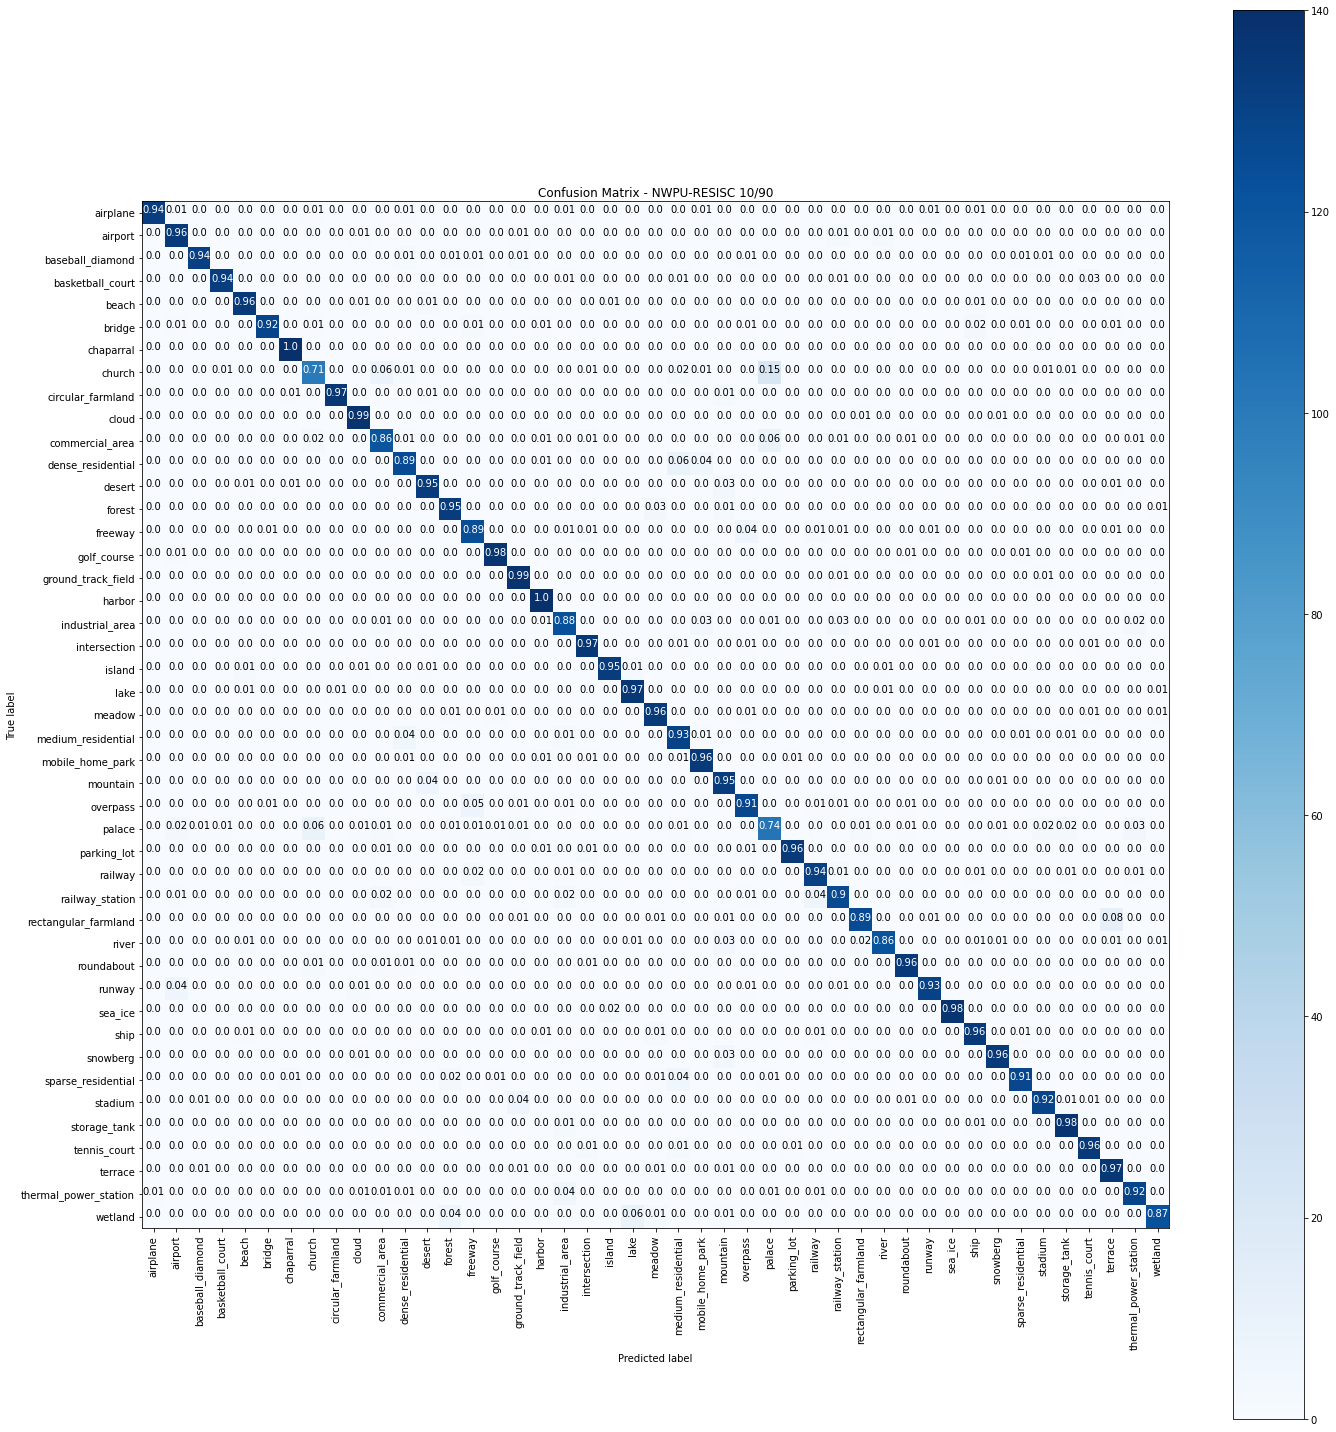

In [ ]:
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix
Y_pred = model.predict_generator(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(val_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix - NWPU-RESISC 10/90')


In [ ]:
clsf_report = pd.DataFrame(classification_report(val_generator.classes, y_pred, target_names=target_names, output_dict=True)).transpose()
print(clsf_report.to_csv('/content/data/result/clsf_report.csv', index= True))
print(clsf_report)